In [3]:
from IPython import get_ipython
ipython = get_ipython()

if ipython is not None:
    ipython.magic("%load_ext autoreload")
    ipython.magic("%autoreload 2")

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as distrib
import torch.optim as optim

In [5]:
from normalizing_flows import NormalizingFlow
from normalizing_flows.flows import AffineFlow, PReLUFlow, StructuredAffineFlow, AffineLUFlow

In [6]:
import matplotlib.pyplot as plt
import datetime

from copy import deepcopy

from tqdm import trange
from tensorboardX import SummaryWriter

In [7]:
now_str = lambda : str(datetime.datetime.now()).replace(" ", "__")

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def gen_samples(batch_size=512):
    x2_dist = distrib.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample((batch_size,))

    x1 = distrib.Normal(loc=.25 * (x2_samples.pow(2)),
                  scale=torch.ones((batch_size,)))
    
    x1_samples = x1.sample()
    return torch.stack([x1_samples, x2_samples]).t()

x_samples = gen_samples(512)

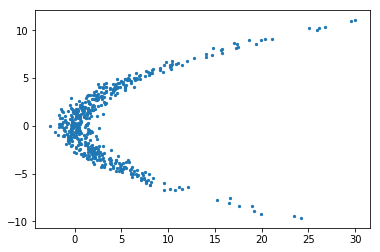

In [10]:
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5)
plt.show()

In [11]:
base_dist = distrib.Normal(loc=torch.zeros(2), scale=torch.ones(2))

In [12]:
X0 = base_dist.sample((1000,)).numpy()

In [13]:
colors = np.zeros(len(X0))

idx_0 = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
colors[idx_0] = 0
idx_1 = np.logical_and(X0[:, 0] >= 0, X0[:, 1] < 0)
colors[idx_1] = 1
idx_2 = np.logical_and(X0[:, 0] >= 0, X0[:, 1] >= 0)
colors[idx_2] = 2
idx_3 = np.logical_and(X0[:, 0] < 0, X0[:, 1] >= 0)
colors[idx_3] = 3

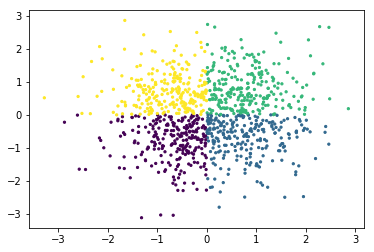

In [14]:
plt.scatter(X0[:, 0], X0[:, 1], s=5, c=colors)

In [27]:
flow = NormalizingFlow(
    dim=2, 
    blocks=([AffineFlow, PReLUFlow]*5 + [AffineFlow]),
    base_density=base_dist,
    flow_length=1
)

opt = optim.Adam(flow.parameters(), lr=1e-3)

#scheduler = optim.lr_scheduler.ExponentialLR(opt, 0.9999)

In [28]:
count_parameters(flow)

41

In [ ]:
writer = SummaryWriter(f"/workspace/sandbox/tensorboard_logs/{now_str()}")

best_loss = torch.Tensor([float("+inf")])

for it in trange(100000):
    opt.zero_grad()
    loss = -flow.final_density.log_prob(x_samples).mean()
    #if loss <= best_loss:
    #    best_loss = loss
    #    best_flow = deepcopy(flow)
    loss.backward()
    if it % 50 == 0:
        writer.add_scalar("loss", loss, it)
    
    if it % 100 == 0:
        f = plt.figure(figsize=(20, 20))
        xhat_samples = flow.final_density.sample((1000, ))
        plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5, c="red")
        plt.xlim(-5, 40)
        plt.ylim(-15, 15)
        plt.savefig(f"to_gif/it_{it}.png")
        plt.close()

    opt.step()
    #scheduler.step()

 58%|█████▊    | 58473/100000 [18:43<256:47:49, 22.26s/it]

In [ ]:
#flow = best_flow

In [ ]:
xhat_samples = flow.final_density.sample((1000, ))
plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5, c="red")
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5, c="blue")
#plt.xlim(0, 60)
#plt.ylim(-15, 15)
plt.show()

In [ ]:
n_flows = len(flow.bijectors)

f, axs = plt.subplots(
    n_flows + 1,
    1,
    figsize=(10, n_flows*12),
    #sharex=True,
    #sharey=True
)

axs[0].scatter(X0[:, 0], X0[:, 1], s=5, c=colors)

cur_x = X0

for ax, bij in zip(axs[1:], flow.bijectors[:n_flows+1]):
    cur_x = bij(torch.Tensor(cur_x)).detach().numpy()
    ax.scatter(cur_x[:, 0], cur_x[:, 1], s=5, c=colors)
    
plt.show()

In [ ]:
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [ ]:
def get_density(cur_z, prev_density, flow):
    density = prev_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(cur_z), None).detach().squeeze())
    return torch.Tensor(density)

In [ ]:
def get_meshes(cur_z, density, grid_side=1000, dim=2):
    mesh = cur_z.reshape([grid_side, grid_side, dim]).transpose(2, 0, 1)
    xx = mesh[0]
    yy = mesh[1]
    zz = density.numpy().reshape([grid_side, grid_side])
    
    return xx, yy, zz

In [ ]:
f, axs = plt.subplots(
    n_flows + 1,
    1,
    figsize=(10, n_flows*12),
    #sharex=True,
    #sharey=True
)

cur_z = z
prev_density = (flow.base_density
                    .log_prob(torch.Tensor(cur_z))
                    .sum(dim=1)
                    .exp().detach())

xx, yy, zz = get_meshes(cur_z, prev_density)

axs[0].contourf(xx, yy, zz, 50, cmap='rainbow')

for ax, bij in zip(axs[1:], flow.bijectors[:n_flows+1]):
    cur_z = bij(torch.Tensor(cur_z)).detach().numpy()
    
    prev_density = get_density(cur_z, prev_density, bij)
    xx, yy, zz = get_meshes(cur_z, prev_density)
    ax.contourf(xx, yy, zz, 50, cmap='rainbow')
    
plt.show()

In [ ]:
list(flow.named_parameters())

___

Trying to specify the params obtained in the tensorflow version, to see if the output corresponds

It's last to first, and prelu_0 is discarded

```
A_0: 
[[12.666909  -3.2123168]
 [-3.8751755  1.0632172]]

A_1: 
[[0.8707053 1.1683432]
 [0.0598104 1.2055824]]

A_2: 
[[0.2163449 0.3574212]
 [0.875208  0.3780005]]

A_3: 
[[1.7268234  0.33141184]
 [0.10429177 0.50915474]]

A_4: 
[[ 2.8008046 -1.29002  ]
 [-1.6140362  4.5898643]]

A_5: 
[[ 4.045219    0.08481489]
 [ 0.25647464 -0.6058725 ]]
```

In [16]:
matrices = [
    [[12.666909,  -3.2123168],
     [-3.8751755,  1.0632172]],

    [[0.8707053, 1.1683432],
     [0.0598104, 1.2055824]],

    [[0.2163449, 0.3574212],
     [0.875208,  0.3780005]],

    [[1.7268234,  0.33141184],
     [0.10429177, 0.50915474]],

    [[ 2.8008046, -1.29002  ],
     [-1.6140362,  4.5898643]],

    [[ 4.045219,    0.08481489],
     [ 0.25647464, -0.6058725 ]],
]

matrices = list(map(torch.Tensor, matrices))

In [17]:
shifts = [
 np.array([-2.7384284,  4.6790996]),
 np.array([1.4246637, 2.5997574]),
 np.array([-1.2736514 , -0.14639635]),
 np.array([-3.702082  ,  0.40250754]),
 np.array([-2.8402073, -3.1306276]),
 np.array([-4.177382,  7.369329])]

In [18]:
alphas = [0.8555014, 0.712254, 0.4994685, 0.37195796, 0.5392429]

In [19]:
flow = NormalizingFlow(
    dim=2, 
    blocks=([AffineFlow, PReLUFlow]*5 + [AffineFlow]),
    base_density=base_dist,
    flow_length=1
)

In [20]:
for i in range(len(flow.bijectors)):
    if i % 2 == 0:
        flow.bijectors[i].weights.data = matrices[i//2]

In [21]:
for i, alpha in enumerate(alphas):
    flow.bijectors[i*2 + 1].alpha.data = torch.Tensor([alpha]).squeeze()

In [22]:
for i, shift in enumerate(shifts):
    flow.bijectors[i*2].shift.data = torch.Tensor([shift]).squeeze()

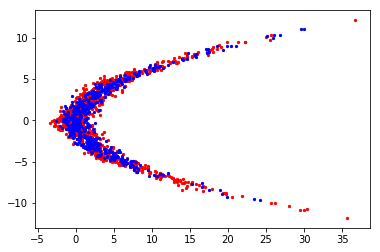

In [23]:
xhat_samples = flow.final_density.sample((1000, ))
plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5, c="red")
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5, c="blue")
#plt.xlim(0, 60)
#plt.ylim(-15, 15)
plt.show()

In [ ]:
x = torch.Tensor(X0)

In [26]:
-flow.final_density.log_prob(x_samples).mean()

tensor(4.2324, grad_fn=<NegBackward>)

In [ ]:
xhat_samples = flow(x)[0].detach()

plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5, c="red")
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5, c="blue")
#plt.xlim(0, 60)
#plt.ylim(-15, 15)
plt.show()

In [ ]:
flow(torch.Tensor([[1, 0]]))[0]

In [ ]:
flow.bijectors[0].weights.data @ x.unsqueeze(-1)

In [ ]:
flow = NormalizingFlow(
    dim=2, 
    blocks=([AffineFlow, PReLUFlow]*5 + [AffineFlow]),
    base_density=base_dist,
    flow_length=1
)

**SUMMARY**

- Tensorflow version always converged, this one never converged
- Looked for the problem everywhere, couldn't find it
- Eventually decided to extract the trained parameters from the tensorflow version
and use them directly here
- Had to figure out how to get the matrices (took me longer than it should, and my
first guess was the right one)
- Realized that even with the right parameters I wasn't getting the same result,
which means I wasn't performing the right operation in the pytorch version
- Finally figured out the order of the matrix multiplication in the affine transforms was incorrect